In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from keras import backend as K 


import math

os.environ["CUDA_VISIBLE_DEVICES"]="3"

# gpu_options = tf.GPUOptions(allow_growth=True,)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

## dataset read and processing

this is the same as ben's original notebook, pretty much

In [4]:
features_sig=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [25]:
alpha = 0.2

def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
#     dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

# column_labels = [
#     r"$m_{JJ}$",
#     r"$m^{(J_1)}$","$m^{(J_2)}$",
#     r"$\tau_{2,1}^{(J_1)}$", r"$\tau_{2,1}^{(J_2)}$"
# ]

column_labels = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
#     "$m^{J_2}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", r"$\tau_{2,1}^{J_2}$"
]


In [26]:
dataset_bg=load_data(features_bg)
# dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_bg2=load_data(features_bg2)
# dataset_bg2=np.hstack((dataset_bg2,np.zeros((len(dataset_bg2),1))))

dataset_sig=load_data(features_sig) 
# dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

## data preparation

making it machine-learnable, setting params for ML methods, setting signal significance

In [27]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 1028

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsb, bg2_srsb, sig_srsb = sr_crit(dataset_bg), sr_crit(dataset_bg2), sr_crit(dataset_sig)

SR_background_data = dataset_bg[bg_srsb]
SB_background_data = dataset_bg[~bg_srsb]

SR_background_sim = dataset_bg2[bg2_srsb]
SB_background_sim = dataset_bg2[~bg2_srsb]

SR_signal = dataset_sig[sig_srsb]
SB_signal = dataset_sig[~sig_srsb]

N_inputs = len(SR_background_data.T) - 1

sigma = 2.00


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
]]

mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, SR_background_sim]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = int(np.round(np.sqrt(len(SR_background_data))*sigma))
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

     # signal events:  493
 signal significance:  2.001420979810858
           s/b ratio:  0.00812512360735711


## Fully supervised

1-d cases are both m1 and m2

In [28]:
#First, let's do fully supervised

Nsig_each = int(len(SR_signal)/2)

SR_sig_draw = np.random.permutation(SR_signal)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

scores_sup = model_sup.predict(X_sup_val,batch_size=batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

In [29]:
from keras import backend as K
import tqdm
#### M J2

tpr_fpr_sup_1d = []

for i in tqdm.tqdm(range(4)):
#     print('Training variable', i)
    
    K.clear_session()
    model_sup1d = Sequential()
    model_sup1d.add(Dense(64, input_dim=1, activation='relu')) 
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(64, activation='relu'))
    model_sup1d.add(Dense(1, activation='sigmoid'))
    model_sup1d.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_sup = model_sup1d.fit(X_sup_train[:,i], Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=0)

    this_scores_sup1d = model_sup1d.predict(X_sup_val[:,i],batch_size=batch_size)
    this_fpr_sup1d, this_tpr_sup1d, _ = roc_curve(Y_sup_val, this_scores_sup1d)
    tpr_fpr_sup_1d.append([this_tpr_sup1d, this_fpr_sup1d])
    del model_sup1d

100%|██████████| 4/4 [00:41<00:00, 10.49s/it]


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


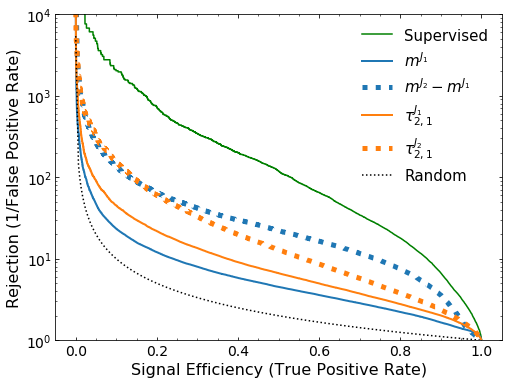

In [30]:
# Plot with banding
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.yscale("log")
plt.ylim([1,1e4])

plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

colors = ['tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']
lss = ['-', ':', '-', ':']
lww = [2, 5, 2, 5]
for i,(label,(tpr,fpr)) in enumerate(zip(column_labels[1:], tpr_fpr_sup_1d)):
    
    plt.plot(tpr,1./fpr,label=label, ls=lss[i], color=colors[i], linewidth=lww[i]) #color='green',ls=":",linewidth=5)
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.savefig('plots/lhco/supervised_deltamjPlus.pdf', bbox_inches='tight')
plt.savefig('plots/lhco/supervised_deltamjPlus.png', bbox_inches='tight')

# SALAD

In [31]:
#Next is SALAD
SALAD_rocs = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
    
    n_data_sb = len(SB_background_sim) - len(SB_signal_to_inject)
    n_data_sr = len(SR_background_sim) - len(SR_signal_to_inject)

    X_SALAD_sb_train = np.concatenate([SB_background_sim, SB_background_data[np.random.choice(len(SB_background_data), n_data_sb, replace=False)], SB_signal_to_inject])
    Y_SALAD_sb_train = np.concatenate([np.zeros(len(SB_background_sim)), np.ones(n_data_sb), np.ones(len(SB_signal_to_inject))])
    
    sbmjj = X_SALAD_sb_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))

    X_SALAD_sb_train = X_SALAD_sb_train[sb_crit]
    Y_SALAD_sb_train = Y_SALAD_sb_train[sb_crit]
    
    X_SALAD_sr_train = np.concatenate([SR_signal_to_inject, SR_background_sim, SR_background_data[np.random.choice(len(SR_background_data), n_data_sr, replace=False)]])
    Y_SALAD_sr_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.zeros(len(SR_background_sim)), np.ones(n_data_sr)])
    
    X_SALAD_sb_train, Y_SALAD_sb_train = shuffle(X_SALAD_sb_train, Y_SALAD_sb_train)
    X_SALAD_sr_train, Y_SALAD_sr_train = shuffle(X_SALAD_sr_train, Y_SALAD_sr_train)
    
    X_SALAD_val = np.concatenate([signal_to_test, SR_background_data_fortest])
    Y_SALAD_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_SALAD_sb = Sequential()
    model_SALAD_sb.add(Dense(64, input_dim=N_inputs + 1, activation='relu')) 
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(64, activation='relu'))
    model_SALAD_sb.add(Dense(1, activation='sigmoid'))
    model_SALAD_sb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)

    hist_SALAD_sb = model_SALAD_sb.fit(
        norm_func(X_SALAD_sb_train), Y_SALAD_sb_train, epochs=EPOCHS,
        batch_size=batch_size,#int(0.1*len(X_SALAD_sb_train)), 
        verbose=0
    )

    def get_weights(data, model):
        yhat = model.predict(data, batch_size=int(0.1*len(data)))
        return np.squeeze(yhat/(1 - yhat))

    # apply weight function
    W_SALAD_sr_train = np.ones_like(Y_SALAD_sr_train)
    W_SALAD_sr_train[Y_SALAD_sr_train == 0] = get_weights(norm_func(X_SALAD_sr_train)[Y_SALAD_sr_train == 0], model_SALAD_sb)

    # run discriminating model
    model_SALAD_sr = Sequential()
    model_SALAD_sr.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(64, activation='relu'))
    model_SALAD_sr.add(Dense(1, activation='sigmoid'))
    model_SALAD_sr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_SALAD_sr = model_SALAD_sr.fit(
        norm_func(X_SALAD_sr_train)[:, 1:], Y_SALAD_sr_train, epochs=EPOCHS,
        batch_size=batch_size, verbose=0,
        sample_weight=W_SALAD_sr_train
    )

    scores_SALAD = model_SALAD_sr.predict(norm_func(X_SALAD_val)[:, 1:], batch_size=batch_size)

    fpr_SALAD, tpr_SALAD, _ = roc_curve(Y_SALAD_val, scores_SALAD)
    SALAD_rocs = SALAD_rocs.append({'fpr': fpr_SALAD, 'tpr': tpr_SALAD}, ignore_index=True)

100%|██████████| 20/20 [11:21<00:00, 34.05s/it]


In [48]:
# plt.plot(tpr_SALAD, 1/fpr_SALAD, label='SALAD')
# plt.plot(tpr_ocwola, 1/fpr_ocwola, label='ocwola')
# plt.yscale('log')
# plt.plot(tpr_SALAD, 1/tpr_SALAD, label='random', color='grey')
# plt.plot(tpr_sup, 1/fpr_sup, label='sup')
# plt.legend()
# plt.show()

## plot features w/ reweighting

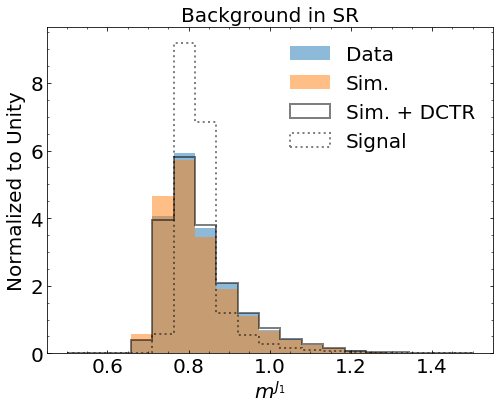

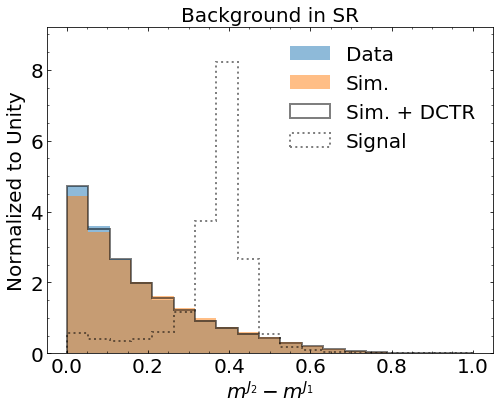

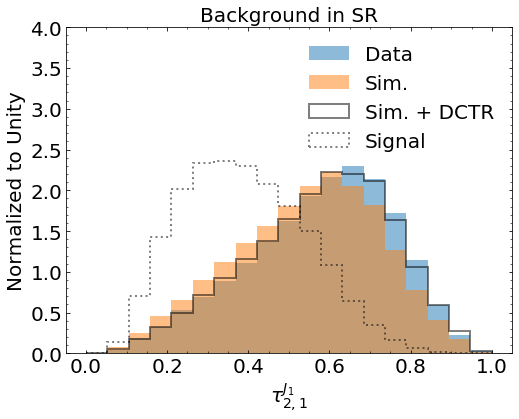

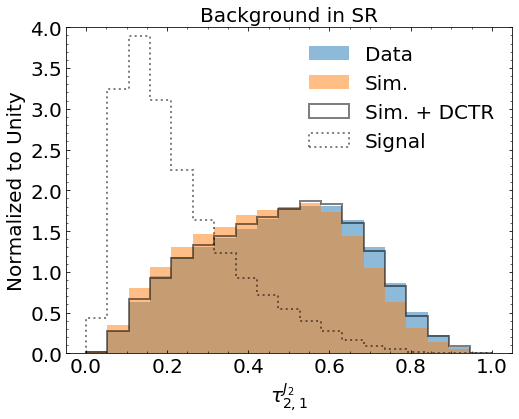

In [43]:
x = X_SALAD_sr_train
y = Y_SALAD_sr_train
sig = X_SALAD_val[Y_SALAD_val == 1]
w = W_SALAD_sr_train

for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(column_labels[i],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    if i == 1: bins = np.linspace(.5, 1.5, 20)
    elif i == 2:
        bins = np.linspace(0, 1., 20)
    else:
        bins = np.linspace(0, 1, 20)
    if (i==4): plt.ylim([0,4.])
    if (i==2): plt.ylim([0,9.2])
    if (i==3): plt.ylim([0,4])

    plt.hist(x[y == 1][:,i],bins=bins,alpha=0.5,density=True,label="Data")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,density=True,label="Sim.")
    plt.hist(x[y == 0][:,i],bins=bins,alpha=0.5,weights=w[y==0],density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.hist(sig[:,i],bins=bins,alpha=0.5,density=True,label="Signal",histtype="step",color="black",ls=":",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
#     if (i==2): plt.legend(frameon=False,fontsize=20,loc="upper left")
    plt.savefig('plots/lhco/features'+str(i)+'_deltamjPlus.pdf',bbox_inches='tight')

## data vs. simulation
SR only

In [33]:
import tqdm

#Now let's do data versus sim
dvsim_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
    
    X_dvsim_train = np.concatenate([SR_signal_to_inject, SR_background_data, SR_background_sim])
    Y_dvsim_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_sim))])

    X_dvsim_train, Y_dvsim_train = shuffle(X_dvsim_train, Y_dvsim_train)

    X_dvsim_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_dvsim_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    

    #     tf.keras.backend.clear_session()
#     K.clear_session()
    
    # average over 5 models

    K.clear_session()
    model_dvsim = Sequential()
    model_dvsim.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(64, activation='relu'))
    model_dvsim.add(Dense(1, activation='sigmoid'))
    model_dvsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_dvsim = model_dvsim.fit(norm_func(X_dvsim_train)[:,1:], Y_dvsim_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_dvsim = model_dvsim.predict(norm_func(X_dvsim_val)[:,1:],batch_size=batch_size)
        
    fpr_dvsim, tpr_dvsim, _ = roc_curve(Y_dvsim_val, scores_dvsim)
    dvsim_rocs = dvsim_rocs.append({'fpr': fpr_dvsim, 'tpr': tpr_dvsim}, ignore_index=True)

100%|██████████| 20/20 [04:20<00:00, 13.02s/it]


## Optimal CWoLa


In [34]:
#Now let's optimal CWoLa
ocwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
#     print('Training i = %i' % i)
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ocwola_train = np.concatenate([SR_signal_to_inject, SR_background_data,SR_background_data_fortest])
    Y_ocwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)),np.ones(len(SR_background_data)),np.zeros(len(SR_background_data_fortest))])

    X_ocwola_train, Y_ocwola_train = shuffle(X_ocwola_train, Y_ocwola_train)

    sbmjj = X_ocwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ocwola_train = X_ocwola_train[sb_crit]
    Y_ocwola_train = Y_ocwola_train[sb_crit]

    X_ocwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ocwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])


    K.clear_session()
    model_ocwola = Sequential()
    model_ocwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(64, activation='relu'))
    model_ocwola.add(Dense(1, activation='sigmoid'))
    model_ocwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist_ocwola = model_ocwola.fit(norm_func(X_ocwola_train)[:,1:], Y_ocwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_ocwola = model_ocwola.predict(norm_func(X_ocwola_val)[:,1:],batch_size=batch_size)
    
    fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_ocwola_val, scores_ocwola)
    ocwola_rocs = ocwola_rocs.append({'fpr': fpr_ocwola, 'tpr': tpr_ocwola}, ignore_index=True)

100%|██████████| 20/20 [04:12<00:00, 12.64s/it]


## CWoLa

In [35]:
#Next is CWoLa
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train)

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(norm_func(X_cwola_train)[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0)

    scores_cwola = model_cwola.predict(norm_func(X_cwola_val)[:,1:],batch_size=batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

100%|██████████| 20/20 [05:33<00:00, 16.66s/it]


## SA-CWoLa: no hyperparameter

the new one that kees came up with

lambda = N_data_SR/N_sim_SR

mean tends to look nicer, use mean. Also just save k-SA-cwola. And also add salad as purple
"LHCO example" at top
error bands/broken down in appendix
supervised case in appendix

In [36]:
#Next is SA-CWoLa
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ksacwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]

    X_ksacwola_train = np.concatenate([
        SR_signal_to_inject, SB_signal_to_inject,
        SR_background_data, SB_background_data,
        SR_background_sim, SB_background_sim
    ])
    Y_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), np.zeros(len(SB_signal_to_inject)),
        np.ones(len(SR_background_data)), np.zeros(len(SB_background_data)),
        np.zeros(len(SR_background_sim)), np.ones(len(SB_background_sim))
    ])
    
    
    W_ksacwola_train = np.concatenate([
        np.ones(len(SR_signal_to_inject)), np.ones(len(SB_signal_to_inject)),
        np.ones(len(SR_background_data)), np.ones(len(SB_background_data)),
        myklambda*np.ones(len(SR_background_sim)),myklambda*np.ones(len(SB_background_sim))
    ])

    X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train = shuffle(X_ksacwola_train, Y_ksacwola_train, W_ksacwola_train)

    sbmjj = X_ksacwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_ksacwola_train = X_ksacwola_train[sb_crit]
    Y_ksacwola_train = Y_ksacwola_train[sb_crit]
    W_ksacwola_train = W_ksacwola_train[sb_crit]
    
    X_ksacwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_ksacwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    # average over 5 models
    K.clear_session()
    #     K.clear_session()
    model_ksacwola = Sequential()
    model_ksacwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(64, activation='relu'))
    model_ksacwola.add(Dense(1, activation='sigmoid'))
    model_ksacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_ksacwola = model_ksacwola.fit(norm_func(X_ksacwola_train)[:,1:], Y_ksacwola_train, epochs=EPOCHS, 
                                     batch_size=batch_size,sample_weight=W_ksacwola_train,
                                     verbose=0
                                    )

    scores_ksacwola = model_ksacwola.predict(norm_func(X_ksacwola_val)[:,1:],batch_size=batch_size)
    
    fpr_ksacwola, tpr_ksacwola, _ = roc_curve(Y_ksacwola_val, scores_ksacwola)
    ksacwola_rocs = ksacwola_rocs.append({'fpr': fpr_ksacwola, 'tpr': tpr_ksacwola}, ignore_index=True)

100%|██████████| 20/20 [11:00<00:00, 33.01s/it]


In [37]:
with np.errstate(divide='ignore'):
    # data v sim
    tpr_pts = np.linspace(0, 1, 10000)

    fpr_interp = [None] * len(dvsim_rocs)

    for i, row in dvsim_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    dvsim_max = np.nanmax(fpr_interp, axis=0).data
    dvsim_min = np.nanmin(fpr_interp, axis=0).data
    dvsim_med = np.median(fpr_interp, axis=0).data
    dvsim_mean = np.nanmean(fpr_interp, axis=0).data
    dvsim_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    dvsim_smean = np.nanmean(sig_interp, axis=0).data
    dvsim_sstd = np.nanstd(sig_interp, axis=0).data

    # optimal CWoLa
    fpr_interp = [None] * len(ocwola_rocs)
    
    for i, row in ocwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ocwola_max = np.nanmax(fpr_interp, axis=0).data
    ocwola_min = np.nanmin(fpr_interp, axis=0).data
    ocwola_med = np.median(fpr_interp, axis=0).data
    ocwola_mean = np.nanmean(fpr_interp, axis=0).data
    ocwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ocwola_smean = np.nanmean(sig_interp, axis=0).data
    ocwola_sstd = np.nanstd(sig_interp, axis=0).data

    # CWoLa
    fpr_interp = [None] * len(cwola_rocs)

    for i, row in cwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    cwola_max = np.nanmax(fpr_interp, axis=0).data
    cwola_min = np.nanmin(fpr_interp, axis=0).data
    cwola_med = np.median(fpr_interp, axis=0).data
    cwola_mean = np.nanmean(fpr_interp, axis=0).data
    cwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    cwola_smean = np.nanmean(sig_interp, axis=0).data
    cwola_sstd = np.nanstd(sig_interp, axis=0).data


    # k-SA-CWoLa
    fpr_interp = [None] * len(ksacwola_rocs)

    for i, row in ksacwola_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    ksacwola_max = np.nanmax(fpr_interp, axis=0).data
    ksacwola_min = np.nanmin(fpr_interp, axis=0).data
    ksacwola_med = np.median(fpr_interp, axis=0).data
    ksacwola_mean = np.nanmean(fpr_interp, axis=0).data
    ksacwola_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    ksacwola_smean = np.nanmean(sig_interp, axis=0).data
    ksacwola_sstd = np.nanstd(sig_interp, axis=0).data
    
    fpr_interp = [None] * len(SALAD_rocs)

    for i, row in SALAD_rocs.iterrows():
        fpr, tpr = row
        interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

        fpr_pts = interp(tpr_pts)
        fpr_interp[i] = fpr_pts

    fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

    SALAD_max = np.nanmax(fpr_interp, axis=0).data
    SALAD_min = np.nanmin(fpr_interp, axis=0).data
    SALAD_med = np.median(fpr_interp, axis=0).data
    SALAD_mean = np.nanmean(fpr_interp, axis=0).data
    SALAD_std = np.nanstd(fpr_interp, axis=0).data
    
    sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
    SALAD_smean = np.nanmean(sig_interp, axis=0).data
    SALAD_sstd = np.nanstd(sig_interp, axis=0).data

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## save bandings

In [38]:
import pickle

LOAD = False
SAVE = True

band_path = 'plots/lhco/bands_corr_deltamj0.2.pkl'

if LOAD:
    with open(band_path, 'rb') as f:
        bands = pickle.load(f)
        tpr_pts = np.linspace(0, 1, 10000)

else:
    bands = {'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
             'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
             'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red', 'ls':':'}),
            'SALAD': (SALAD_max, SALAD_med, SALAD_min, SALAD_mean, SALAD_std, SALAD_smean, SALAD_sstd, {'label':'SALAD', 'color':'tab:purple'}),
#             'old-sacwola': (sacwola_max, sacwola_med, sacwola_min, sacwola_mean, sacwola_std, sacwola_smean, sacwola_sstd, {'label':"old-SA-CWoLa, $\lambda = {}$".format(mylambda), 'color':'orange', 'ls':':'}),
            'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'orange'}),
#             'hl-sacwola': (kbsacwola_max, kbsacwola_med, kbsacwola_min, kbsacwola_mean, kbsacwola_std, kbsacwola_smean, kbsacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(mykblambda), 'color':'orange', 'ls': ':'})
            }
if SAVE:
    with open(band_path, 'wb') as f:
        pickle.dump(bands, f)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


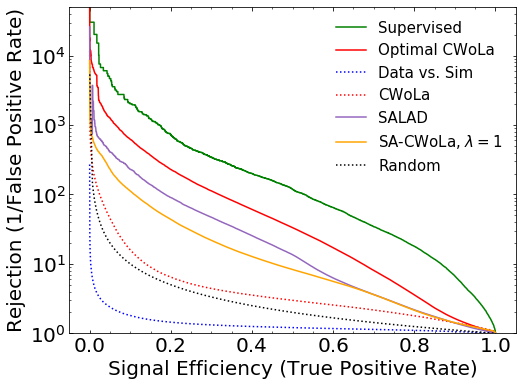

In [39]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
# plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)


for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('plots/lhco/combined_corr_deltamjPlus.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_corr_deltamjPlus.png', pdf=False, bbox_inches='tight')

# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.pdf', bbox_inches='tight', padinches=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


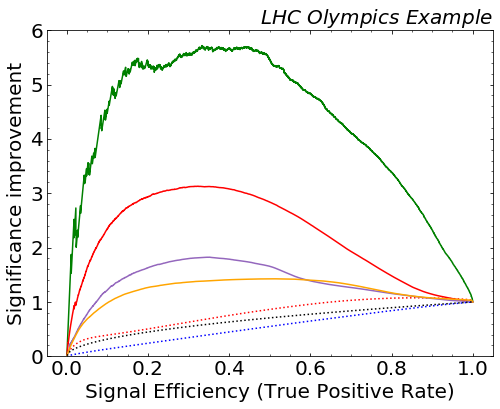

In [40]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# plt.yscale("log")
plt.ylim([0, 6])

plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')
# plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5)

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
#         if ERR:
#             plt.fill_between(tpr_pts, tpr_pts*np.sqrt(lower), tpr_pts*np.sqrt(upper), alpha=.2, **bands[band][-1])
plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
# plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.title('$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
plt.savefig('plots/lhco/combined_relsigs_corr_deltamjPlus.pdf', pdf=True, bbox_inches='tight')
plt.savefig('plots/lhco/combined_relsigs_corr_deltamjPlus.png', pdf=False, bbox_inches='tight')

# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/imperfect_sim_averaged_5/toy_lambda_50.pdf', bbox_inches='tight', padinches=0)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


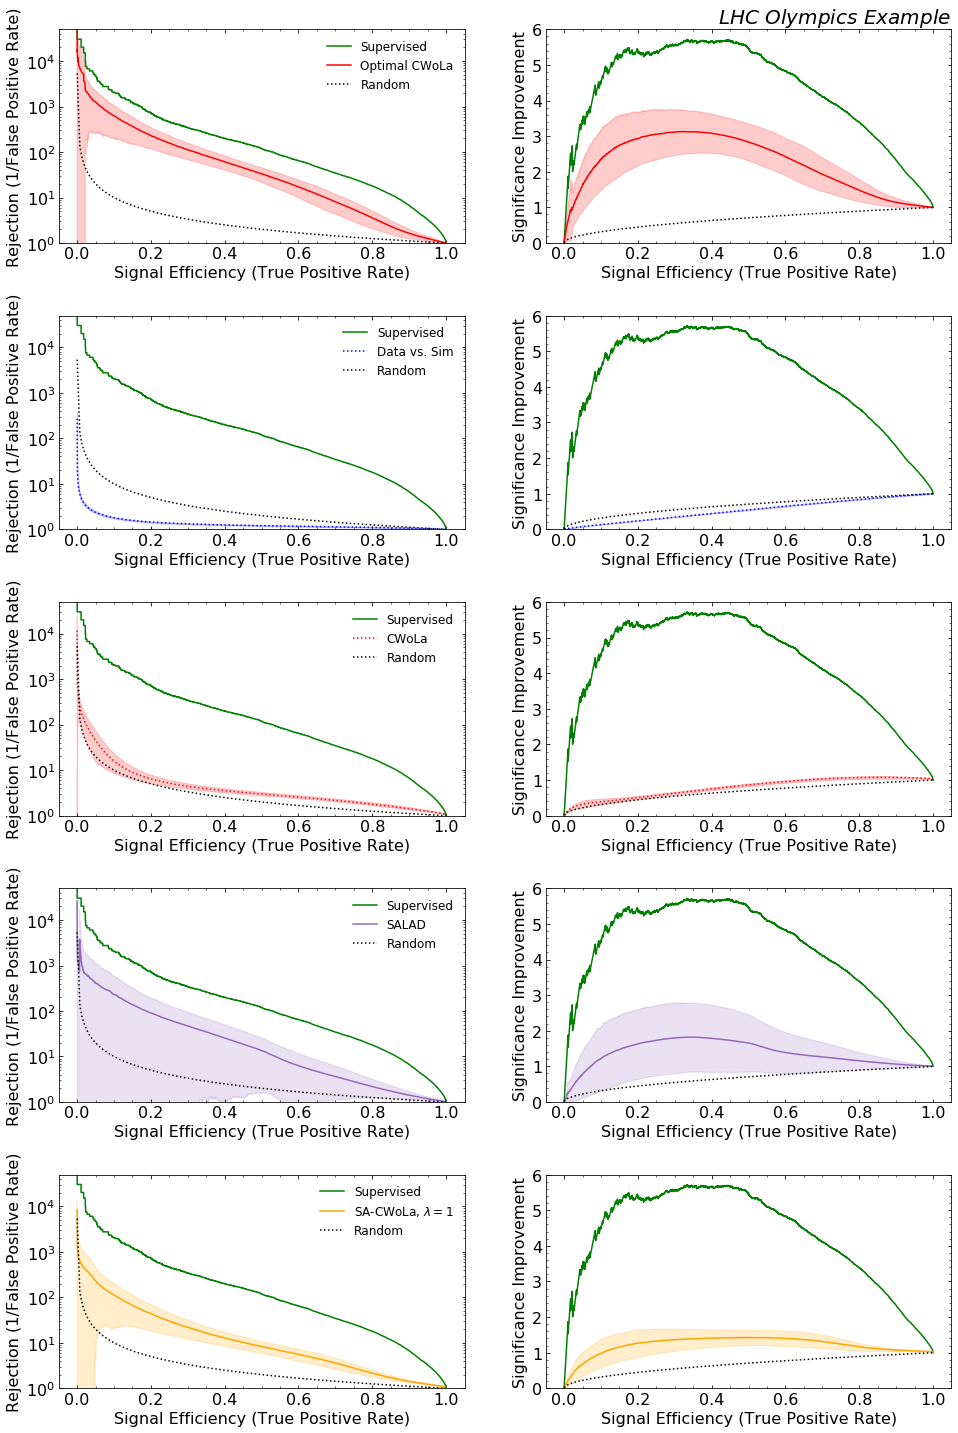

In [41]:
 # Plot individual bands

STD = True

band_names = [k for k in bands.keys() if k not in ['old-sacwola', 'hl-sacwola']]

fig = plt.figure(figsize=(16, 5*len(band_names))) 
gs = gridspec.GridSpec(len(band_names)*2 - 1, 2, height_ratios=[1, 0.1,]*(len(band_names) - 1) + [1,])


for i, key in enumerate(band_names):
    line_max, line_med, line_min, line_mean, line_std, line_smean, line_sstd, opt = bands[key]
    for j in range(2):
#         row = 2 * math.floor(i / 2)
#         col = i % 2

        ax0 = plt.subplot(gs[2*i, j])

        ax0.yaxis.set_ticks_position('both')
        ax0.xaxis.set_ticks_position('both')
        ax0.tick_params(direction="in",which="both")
        ax0.minorticks_on()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

        
        if j == 0:
            plt.ylim([1,5*1e4])
            plt.yscale("log")
            plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')
            plt.plot(tpr_pts, line_mean, **opt)
            plt.fill_between(tpr_pts, line_mean - line_std, line_mean + line_std, color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=16)
            plt.legend(frameon=False,fontsize=12,loc="upper right")
        else:
            plt.ylim([0, 6])
            plt.plot(tpr_sup,tpr_sup/np.sqrt(fpr_sup),label="Supervised",color='green')
            plt.plot(tpr_pts, tpr_pts*line_smean, **opt)
            plt.fill_between(tpr_pts, tpr_pts*(line_smean - line_sstd), tpr_pts*(line_smean + line_sstd), color=opt['color'], alpha=0.2)        
            plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")
            plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=16)
            plt.ylabel(r"Significance Improvement",fontsize=16)
            if i == 0:
                plt.title('$LHC$ $Olympics$ $Example$', fontsize=20, loc='right')
    
    #     plt.plot(tpr_sup1d,1./fpr_sup1d,label="Supervised ($x_1$ only)",color='green',ls=":",linewidth=5


#         plt.title(opt['label'], fontsize=16)
    #  + ', '.join(column_labels)
# fig.suptitle("Correlated LHCO Example\nMean and Standard Deviation of {} models".format(n_injections),fontsize=20,y=.93)

plt.savefig('plots/lhco/separate_corr_deltamjPlus.png', bbox_inches='tight', padinches=0)
plt.savefig('plots/lhco/separate_corr_deltamjPlus.pdf', bbox_inches='tight', padinches=0)


## feature plots

plots for verification, i suppose

In [ ]:
#### fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(1, 10, .1)
    
plt.hist(SR_background_data[:,0],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 0], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,0],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 0], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,0],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{JJ}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(0, 1.5, .025)
    
plt.hist(SR_background_data[:,1],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 1], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,1],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 1], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,1],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{J_1}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()

fig = plt.figure(figsize=(7, 5)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bins = np.arange(0,1.5, .025)
    
plt.hist(SR_background_data[:,2],bins=bins,alpha=0.5,label="Background (SR)",)#hatch='//')
plt.hist(SR_background_sim[:, 2], bins=bins, histtype='step', 
         label='Background (SR sim)', color='tab:blue')
plt.hist(SB_background_data[:,2],bins=bins,alpha=0.5,label="Background (SB)",)#hatch='\\')
plt.hist(SB_background_sim[:, 2], bins=bins, histtype='step', 
         label='Background (SB sim)', color='tab:orange')
plt.hist(SR_signal[:,2],bins=bins,alpha=0.5,label="Signal",histtype='step',color='black')
plt.legend(frameon=False,fontsize=14,loc="upper right")
# plt.ylim([0,30000])
plt.ylim(.5e0, 1e6)
plt.xlabel("$m_{J_2}$",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.yscale('log')
# plt.savefig('plots/x0.png', bbox_inches='tight', padinches=0)
# plt.savefig('plots/x0.pdf', bbox_inches='tight', padinches=0)
plt.show()

## legacy

left this stuff for future verification. Moving to toy model method bc it is cleaner (and better to compare)

In [ ]:
def make_plot(pyth,sig,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",myname="mjj",myscale=5,dolog=True,donormalize=False,myloc="upper left"):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="Background",density=donormalize)
    nhmjj,_,_=plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
    plt.legend(frameon=False,fontsize=20,loc=myloc)
    plt.xlabel(r""+mylabel,fontsize=20)

    plt.tight_layout()
    plt.savefig("plots/"+myname+".pdf")
    pass

In [ ]:
make_plot(1000*dataset_bg[:,0],1000*dataset_sig[:,0][0:1000],np.linspace(1000,10000,100),"$m_{JJ}$ [GeV]","mjj",myloc="upper right")

In [ ]:
make_plot(1000*dataset_bg[:,1],1000*dataset_sig[:,1][0:1000],np.linspace(0,1000,100),"$m_{J_{1}}$ [GeV]","minmj",2,True,False,"upper right")

In [ ]:
make_plot(1000*dataset_bg[:,2],1000*dataset_sig[:,2][0:1000],np.linspace(0,1000,100),"$m_{J_{2}}-m_{J_{1}}$ [GeV]","maxmj",2,True,False,"upper right")

In [ ]:
make_plot(dataset_bg[:,3],dataset_sig[:,3],np.linspace(0,1,100),"$\\tau_{21}^{J_{1}}$","mintau21",1.4,False,True,"upper right")

In [ ]:
make_plot(dataset_bg[:,4],dataset_sig[:,4],np.linspace(0,1,100),"$\\tau_{21}^{J_{2}}$","maxtau21",2.1,False,True,"upper right")

In [ ]:
#Make the dataset

dataset_sig_shifted = dataset_sig.copy()
dataset_bg_shifted = dataset_bg.copy()
dataset_bg2_shifted = dataset_bg2.copy()

shift = 0.1

dataset_sig_shifted[:,1] = dataset_sig_shifted[:,1] + shift*dataset_sig_shifted[:,0]
dataset_sig_shifted[:,2] = dataset_sig_shifted[:,2] + shift*dataset_sig_shifted[:,0]

dataset_bg_shifted[:,1] = dataset_bg_shifted[:,1] + shift*dataset_bg_shifted[:,0]
dataset_bg_shifted[:,2] = dataset_bg_shifted[:,2] + shift*dataset_bg_shifted[:,0]

dataset_bg2_shifted[:,1] = dataset_bg2_shifted[:,1] + shift*dataset_bg2_shifted[:,0]
dataset_bg2_shifted[:,2] = dataset_bg2_shifted[:,2] + shift*dataset_bg2_shifted[:,0]

In [ ]:
#CWoLa
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_sacwola = Sequential()
model_sacwola.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(1, activation='sigmoid'))
model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1500]
X_sig_inject2 = dataset_sig_shifted[1500:3000]
X_sig_test = dataset_sig_shifted[1500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

mylambda = 0.5

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_sacwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_sacwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_sacwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_test, preds_hold)
fprSB_sacwola, tprSB_sacwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

###

mylambda = 0.

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_cwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_cwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_cwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_cwola, tpr_cwola, _ = roc_curve(Y_test, preds_hold)
fprSB_cwola, tprSB_cwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

In [ ]:
#Optimal CWoLa

model_cwola_optimal = Sequential()
model_cwola_optimal.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(1, activation='sigmoid'))
model_cwola_optimal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

In [ ]:
preds_hold = model_cwola_optimal.predict(X_test,batch_size=10000)[:,0]
fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_test, preds_hold)

In [ ]:
#SALAD

model_reweighter = Sequential()
model_reweighter.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(1, activation='sigmoid'))
model_reweighter.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_sig_SB_low_long = X_sig_inject[(X_sig_inject[:,0] > SB_low_long)*(X_sig_inject[:,0] < SR_low)][:,0:5]
X_sig_SB_high_long = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high_long)][:,0:5]
X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train_forw = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,0:5]

preds = model_reweighter.predict(np.concatenate([X_sig_SR_train_forw,X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_sig_SR_train_forw)),np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad = Sequential()
model_salad.add(Dense(64, input_dim=4, activation='relu')) 
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(1, activation='sigmoid'))
model_salad.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_datavsim = Sequential()
model_datavsim.add(Dense(64, input_dim=4, activation='relu')) 
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(1, activation='sigmoid'))
model_datavsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=weights_salad)
model_datavsim.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

In [ ]:
ww = model_reweighter.predict(X_bg2_SR_train_forw,batch_size=10000)
ww = ww / (1.-ww)

In [ ]:
mynames=["$m_{J_1}$ [TeV]","$m_{J_2}-m_{J_1}$ [TeV]",r"$\tau_{21}^{J_1}$",r"$\tau_{21}^{J_2}$"]
for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(mynames[i-1],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    
    if (i==4): plt.ylim([0,4.])
    if (i==2): plt.ylim([0,7.2])
    if (i==3): plt.ylim([0,4])

    plt.hist(X_bg_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Data")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Sim.")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,weights=ww,density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.hist(X_sig_SR_test[:,i-1],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Signal",histtype="step",color="black",ls=":",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
    if (i==2): plt.legend(frameon=False,fontsize=20,loc="upper left")
    plt.savefig('SA-CWoLa/features'+str(i)+'.pdf',bbox_inches='tight')

In [ ]:
preds_hold = model_salad.predict(X_test,batch_size=10000)[:,0]
fpr_salad, tpr_salad, _ = roc_curve(Y_test, preds_hold)

In [ ]:
preds_hold = model_datavsim.predict(X_test,batch_size=10000)[:,0]
fpr_datavsim, tpr_datavsim, _ = roc_curve(Y_test, preds_hold)

In [ ]:
#Let's train a fully supervised classifier
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Xfully_train = np.concatenate([X_sig_SR_train,X_bg_SR_train])
#Yfully_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train))])

model.fit(X_test,Y_test, epochs=10, batch_size=200,validation_data=(X_test,Y_test))
preds = model.predict(X_test,batch_size=10000)
fpr_fully, tpr_fully, _ = roc_curve(Y_test, preds)

In [ ]:
#Save the mdoels.

model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/model.h5")

model_json = model_sacwola.to_json()
with open("models/model_sacwola.json", "w") as json_file:
    json_file.write(model_json)
model_sacwola.save_weights("models/model_sacwola.h5")

model_json = model_cwola.to_json()
with open("models/model_cwola.json", "w") as json_file:
    json_file.write(model_json)
model_cwola.save_weights("models/model_cwola.h5")

model_json = model_cwola_optimal.to_json()
with open("models/model_cwola_optimal.json", "w") as json_file:
    json_file.write(model_json)
model_cwola_optimal.save_weights("models/model_cwola_optimal.h5")

model_json = model_reweighter.to_json()
with open("models/model_reweighter.json", "w") as json_file:
    json_file.write(model_json)
model_reweighter.save_weights("models/model_reweighter.h5")

model_json = model_salad.to_json()
with open("models/model_salad.json", "w") as json_file:
    json_file.write(model_json)
model_salad.save_weights("models/model_salad.h5")

model_json = model_datavsim.to_json()
with open("models/model_datavsim.json", "w") as json_file:
    json_file.write(model_json)
model_datavsim.save_weights("models/model_datavsim.h5")

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
plt.plot(tpr_datavsim,1./fpr_datavsim,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,1./fpr_salad,label="SALAD",color="blue")
plt.plot(tpr_ocwola,1./fpr_ocwola,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,1./fpr_sacwola,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.ylim([1,1e6])
plt.tight_layout()
plt.savefig('SA-CWoLa/roc_shifted.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,tpr_fully/fpr_fully**0.5,label="Supervised",color="green")
plt.plot(tpr_datavsim,tpr_datavsim/fpr_datavsim**0.5,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,tpr_salad/fpr_salad**0.5,label="SALAD",color="blue")
plt.plot(tpr_ocwola,tpr_ocwola/fpr_ocwola**0.5,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,tpr_cwola/fpr_cwola**0.5,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,tpr_sacwola/fpr_sacwola**0.5,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,tpr_fully/tpr_fully**0.5,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance Improvement",fontsize=20)
#plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.tight_layout()
plt.ylim([0,5])
plt.savefig('SA-CWoLa/sic_shifted.pdf',bbox_inches='tight')

In [ ]:
K.clear_session()

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

#Now, a lambda scan, with signal

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1500]
X_sig_inject2 = dataset_sig_shifted[1500:3000]
X_sig_test = dataset_sig_shifted[1500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

lambdas = []
max_sic = []
aucs = []
maxSB_sic = []
aucsSB = []

#mylambda = 0.5
for mylambda in np.linspace(0,1,20):
    
    print(mylambda,"\n\n\n")
    lambdas += [mylambda]
    
    max_sic_foravg = []
    aucs_foravg = []
    maxSB_sic_foravg = []
    aucsSB_foravg = []
    
    for k in range(1):
        
        model_sacwola_scan = Sequential()
        model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(1, activation='sigmoid'))
        model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                                 X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
        Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                                 np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
        w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
        w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
        w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
        w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
        W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                                 -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

        X_testSB = np.concatenate([X_bg_SR_train,X_bg_SB_low_test,X_bg_SB_high_test])
        Y_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_bg_SB_high_test))])
        w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_low_test))
        w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_high_test))
        W_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_bg_SB_high_test))])

        model_sacwola_scan.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

        preds_hold = model_sacwola_scan.predict(X_test,batch_size=10000)[:,0]
        preds_holdSB = model_sacwola_scan.predict(X_testSB,batch_size=10000)[:,0]
        fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
        fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)
        myauc_scan = roc_auc_score(Y_test, preds_hold)
        myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

        mysic = tpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]/fpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]**0.5
        mysic_SB = tprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]/fprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]**0.5
        print("   ",k,max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5),myauc_scan,mysic)
        max_sic_foravg += [mysic] #max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
        aucs_foravg += [myauc_scan]
        maxSB_sic_foravg += [mysic_SB] #max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
        aucsSB_foravg += [myaucSB_scan]
        pass
    
    max_sic+=[np.mean(max_sic_foravg)]
    aucs+=[np.mean(aucs_foravg)]
    maxSB_sic+=[np.mean(maxSB_sic_foravg)]
    aucsSB+=[np.mean(aucsSB_foravg)]

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,aucs,label="Signal versus Background",linewidth=3)
plt.plot(lambdas,aucsSB,label="Background in SR versus SB",ls="--",linewidth=3)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])
plt.savefig('SA-CWoLa/lambdascan_AUC.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,max_sic,label="Signal versus Background",linewidth=3)
plt.plot(lambdas,maxSB_sic,label="Background in SR versus SB",ls="--",linewidth=3)
plt.axhline(1.,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"$\epsilon_S$ / $\sqrt{\epsilon_B}$ @ $\epsilon_S = 50\%$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0.2,5])
plt.savefig('SA-CWoLa/lambdascan_sic.pdf',bbox_inches='tight')

In [ ]:
#Now, a lambda scan, without signal

'''
SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1]
X_sig_inject2 = dataset_sig_shifted[1:2]
X_sig_test = dataset_sig_shifted[500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

lambdas_NO = []
max_sic_NO = []
aucs_NO = []
maxSB_sic_NO = []
aucsSB_NO = []

#mylambda = 0.5
for mylambda in np.linspace(0,1,20):
    
    model_sacwola_scan = Sequential()
    model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(64, activation='relu'))
    model_sacwola_scan.add(Dense(1, activation='sigmoid'))
    model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                             X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
    Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                             np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
    w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
    w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
    W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                             -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

    X_testSB = np.concatenate([X_bg_SR_train,X_bg_SB_low_test,X_bg_SB_high_test])
    Y_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_bg_SB_high_test))])
    w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_low_test))
    w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_high_test))
    W_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_bg_SB_high_test))])

    model_sacwola_scan.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

    preds_hold = model_sacwola_scan.predict(X_test,batch_size=10000)[:,0]
    preds_holdSB = model_sacwola_scan.predict(X_testSB,batch_size=10000)[:,0]
    fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
    fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)
    myauc_scan = roc_auc_score(Y_test, preds_hold)
    myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

    lambdas_NO += [mylambda]
    max_sic_NO += [max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
    aucs_NO += [myauc_scan]
    maxSB_sic_NO += [max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
    aucsSB_NO += [myaucSB_scan]
'''

In [ ]:
#plt.plot(lambdas,aucs_NO)
#plt.plot(lambdas,aucsSB_NO)

In [ ]:
#plt.plot(lambdas,max_sic_NO)
#plt.plot(lambdas,maxSB_sic_NO)

In [ ]:
#Try a fit.

In [ ]:
from ATLAS_anomaly_detection.fit_utils import *

In [ ]:
n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[:,0][0:0]]),np.linspace(2600,5000,30))

In [ ]:
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
#myout = get_fit_params(n,b,n**0.5,[28],verbose=False,npar=4)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$m_{jj}$ [GeV]",fontsize=20)
plt.ylabel("Events per bin",fontsize=20)

_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30),alpha=0.5,label="Background")
_,_,_=plt.hist(1000*dataset_sig[0:1500][:,0],np.linspace(2600,5000,30),label="Signal")
#_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)],np.linspace(2600,5000,30))
plt.plot(0.5*(b[ 1:]+b[:-1]) ,80*myout['ydata_fit']/100,color="black",ls='--',linewidth=2,label="Fit (KS $p =$ "+"%0.2f" % myout["fit_p0"]+")")
plt.ylim(10,1e5)
plt.axvline(x=SR_low*1000,color="black",ls=":")
plt.axvline(x=SR_high*1000,color="black",ls=":")
plt.axvline(x=SB_low*1000,color="black",ls=":")
plt.axvline(x=SB_high*1000,color="black",ls=":")
plt.text(3430,4e4,"SR",fontsize=20)
plt.text(3720,4e4,"SB",fontsize=20)
plt.text(3120,4e4,"SB",fontsize=20)
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")
plt.savefig('SA-CWoLa/mjjfit.pdf',bbox_inches='tight')

In [ ]:
#myout

In [ ]:
print("mean",np.mean(myout['residuals']))
print("std",np.std(myout['residuals']))

In [ ]:
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

In [ ]:
n2 = n-0.9*myout['residuals']*n**0.5
myout2 = get_fit_params(n2,b,n**0.5,range(9,14),verbose=False)
print("mean",np.mean(myout2['residuals']))
print("std",np.std(myout2['residuals']))
plt.plot(myout2['residuals'])
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

In [ ]:
myout['Zval']

In [ ]:
B = len(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)])
S = len(dataset_sig[0:int(500)][:,0][(dataset_sig[0:int(500)][:,0] > SR_low)*(dataset_sig[0:int(500)][:,0] < SR_high)])
print(S/B,S/B**0.5)

In [ ]:
fitvals = []
injectvals = []
n,b=np.histogram(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30))
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
mycor = myout['residuals']*n**0.5
for s in np.linspace(0,10,20):
    mult = 310.
    B = len(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)])
    S = len(dataset_sig[0:int(s*mult)][:,0][(dataset_sig[0:int(s*mult)][:,0] > SR_low)*(dataset_sig[0:int(s*mult)][:,0] < SR_high)])
    n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[0:int(s*mult)][:,0]]),np.linspace(2600,5000,30))
    n = n - 0.99*mycor
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    print(s,S/B**0.5,myout['Zval'])
    injectvals+=[S/B**0.5]
    fitvals+=[myout['Zval']]

In [ ]:
plt.plot(injectvals,fitvals)
plt.plot(injectvals,injectvals,ls=":",color="gray")
plt.xlabel(r"Injected $s/\sqrt{b}$ in SR")
plt.ylabel(r"Fitted significance")

In [ ]:
X_sig_test_all = dataset_sig_shifted[1500:3000]
X_sig_SR_test_all = X_sig_test_all[:,1:5]
M_sig_SR_test_all = X_sig_test_all[:,0]
X_bg_SR_all = dataset_bg_shifted[:,0:5]
X_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,1:5]
M_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,0]

X_test_all = np.concatenate([X_sig_SR_test_all,X_bg_SR_test_all])
Y_test_all = np.concatenate([np.ones(len(X_sig_SR_test_all)),np.zeros(len(X_bg_SR_test_all))])
M_test_all = np.concatenate([M_sig_SR_test_all,M_bg_SR_test_all])

In [ ]:
preds_fully_all = model.predict(X_test_all,batch_size=10000)
preds_optimal_cwola = model_cwola_optimal.predict(X_test_all,batch_size=10000)
preds_sacwola = model_sacwola.predict(X_test_all,batch_size=10000)
preds_cwola = model_cwola.predict(X_test_all,batch_size=10000)
preds_salad = model_salad.predict(X_test_all,batch_size=10000)
preds_datavsim = model_datavsim.predict(X_test_all,batch_size=10000)

In [ ]:
n,b,_=plt.hist(preds_optimal_cwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_optimal_cwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

In [ ]:
n,b,_=plt.hist(preds_sacwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_sacwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

In [ ]:
q = np.quantile(preds_optimal_cwola[Y_test_all==0],0.9)
plt.hist(1000*M_test_all[(Y_test_all==0) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.hist(1000*M_test_all[(Y_test_all==1) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.yscale('log')

In [ ]:
cutval = []
sigval_fit = []
sigval_fit_sacwola = []
sigval_fit_cwola = []
sigval_fit_salad = []
sigval_fit_datavsim = []
sigval = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitwithsig.pdf',bbox_inches='tight')

In [ ]:
cutval = []
sigval2_fit = []
sigval2_fit_sacwola = []
sigval2_fit_cwola = []
sigval2_fit_salad = []
sigval2_fit_datavsim = []
sigval2 = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval2_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval2_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval2_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval2_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitwithsig_optimal.pdf',bbox_inches='tight')

In [ ]:
#Now, do a training with no signal and run the same fit?

In [ ]:
#CWoLa
model_sacwola_NO = Sequential()
model_sacwola_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(1, activation='sigmoid'))
model_sacwola_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

mylambda = 0.5

X_train = np.concatenate([X_bg_SR_train,X_bg_SB_low,X_bg_SB_high,X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_bg_SB_high)),
                         np.ones(len(X_bg2_SR_train)),np.zeros(len(X_bg2_SB_low)),np.zeros(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_low))
w_high = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_high))
w2_low = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_low))
w2_high = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_bg_SB_high)),
                         -mylambda*np.ones(len(X_bg2_SR_train)),-mylambda*w_low*np.ones(len(X_bg2_SB_low)),-mylambda*w_high*np.ones(len(X_bg2_SB_high))])

model_sacwola_NO.fit(X_train,Y_train, epochs=10, batch_size=200,sample_weight=W_train)

In [ ]:
#Optimal CWoLa

model_cwola_optimal_NO = Sequential()
model_cwola_optimal_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(1, activation='sigmoid'))
model_cwola_optimal_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal_NO.fit(X_train,Y_train, epochs=10, batch_size=200)

In [ ]:
#SALAD

model_reweighter_NO = Sequential()
model_reweighter_NO.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(1, activation='sigmoid'))
model_reweighter_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter_NO.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]

preds = model_reweighter_NO.predict(np.concatenate([X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad_NO = Sequential()
model_salad_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(1, activation='sigmoid'))
model_salad_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad_NO.fit(Xs_train,Ys_train, epochs=10, batch_size=200,sample_weight=weights_salad)

In [ ]:
model_json = model_cwola_optimal_NO.to_json()
with open("models/model_cwola_optimal_NO.json", "w") as json_file:
    json_file.write(model_json)
model_cwola_optimal_NO.save_weights("models/model_cwola_optimal_NO.h5")

model_json = model_sacwola_NO.to_json()
with open("models/model_sacwola_NO.json", "w") as json_file:
    json_file.write(model_json)
model_sacwola_NO.save_weights("models/model_sacwola_NO.h5")

model_json = model_salad_NO.to_json()
with open("models/model_salad_NO.json", "w") as json_file:
    json_file.write(model_json)
model_salad_NO.save_weights("models/model_salad_NO.h5")

In [ ]:
#preds_fully_all_NO = model_NO.predict(X_test_all,batch_size=10000)
preds_optimal_cwola_NO = model_cwola_optimal_NO.predict(X_test_all,batch_size=10000)
preds_sacwola_NO = model_sacwola_NO.predict(X_test_all,batch_size=10000)
#preds_cwola_NO = model_cwola_NO.predict(X_test_all,batch_size=10000)
preds_salad_NO = model_salad_NO.predict(X_test_all,batch_size=10000)
#preds_datavsim_NO = model_datavsim_NO.predict(X_test_all,batch_size=10000)

In [ ]:
cutval_NO = []
sigval_fit_NO = []
sigval_fit_sacwola_NO = []
sigval_fit_cwola_NO = []
sigval_fit_salad_NO = []
sigval_fit_datavsim_NO = []
sigval_NO = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
        
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval_NO+=[2**(-myqexp)] #myq]
    sigval_fit_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']
    #sigval_NO+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_sacwola_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_salad_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5]
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO,label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO,label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitnosig_optimal.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO-sigval_fit_NO[0],label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO-sigval_fit_sacwola_NO[0],label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO-sigval_fit_salad_NO[-0],label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.axhline(y=0,color="gray",ls=":")
plt.axhline(y=1,color="gray",ls=":")
plt.axhline(y=-1,color="gray",ls=":")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("$Shifted$ SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitnosig_optimal_shifted.pdf',bbox_inches='tight')

## Old

In [ ]:
def computemjj_np(event):
    px1 = event[:,0]
    py1 = event[:,1]
    pz1 = event[:,2]
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[:,3]**2)
    
    px2 = event[:,7]
    py2 = event[:,8]
    pz2 = event[:,9]
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[:,10]**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.sqrt(m2)

In [ ]:
signal_np = signal.to_numpy()
pythia_np = pythia.to_numpy()
herwig_np = herwig.to_numpy()

In [ ]:
mjj_signal = computemjj_np(signal_np)
mjj_pythia = computemjj_np(pythia_np)
mjj_herwig = computemjj_np(herwig_np)

First thing to do is to make some plots of the basic features.

In [ ]:
minmass_pythia = np.array(pythia[['mj1','mj2']].min(axis=1))
maxmass_pythia = np.array(pythia[['mj1','mj2']].max(axis=1))
minmass_herwig = np.array(herwig[['mj1','mj2']].min(axis=1))
maxmass_herwig = np.array(herwig[['mj1','mj2']].max(axis=1))
minmass_signal = np.array(signal[['mj1','mj2']].min(axis=1))
maxmass_signal = np.array(signal[['mj1','mj2']].max(axis=1))

In [ ]:
tau21A_pythia = pythia_np[:,5]/(0.00001+pythia_np[:,4])
tau21B_pythia = pythia_np[:,12]/(0.00001+pythia_np[:,11])
m1_pythia = pythia_np[:,3]
m2_pythia = pythia_np[:,10]
mymasses_pythia = np.concatenate((np.reshape(m1_pythia,[len(m1_pythia),1]),np.reshape(m2_pythia,[len(m2_pythia),1])),axis=1)
mytaus_pythia = np.concatenate((np.reshape(tau21A_pythia,[len(tau21A_pythia),1]),np.reshape(tau21B_pythia,[len(tau21B_pythia),1])),axis=1)
order_pythia = [np.argmax(mymasses_pythia[i]) for i in range(len(mymasses_pythia))]
tau21a_pythia = [mytaus_pythia[i][order_pythia[i]] for i in range(len(order_pythia))]
tau21b_pythia = [mytaus_pythia[i][1-order_pythia[i]] for i in range(len(order_pythia))]

tau21A_herwig = herwig_np[:,5]/(0.00001+herwig_np[:,4])
tau21B_herwig = herwig_np[:,12]/(0.00001+herwig_np[:,11])
m1_herwig = herwig_np[:,3]
m2_herwig = herwig_np[:,10]
mymasses_herwig = np.concatenate((np.reshape(m1_herwig,[len(m1_herwig),1]),np.reshape(m2_herwig,[len(m2_herwig),1])),axis=1)
mytaus_herwig = np.concatenate((np.reshape(tau21A_herwig,[len(tau21A_herwig),1]),np.reshape(tau21B_herwig,[len(tau21B_herwig),1])),axis=1)
order_herwig = [np.argmax(mymasses_herwig[i]) for i in range(len(mymasses_herwig))]
tau21a_herwig = [mytaus_herwig[i][order_herwig[i]] for i in range(len(order_herwig))]
tau21b_herwig = [mytaus_herwig[i][1-order_herwig[i]] for i in range(len(order_herwig))]

tau21A_signal = signal_np[:,5]/(0.00001+signal_np[:,4])
tau21B_signal = signal_np[:,12]/(0.00001+signal_np[:,11])
m1_signal = signal_np[:,3]
m2_signal = signal_np[:,10]
mymasses_signal = np.concatenate((np.reshape(m1_signal,[len(m1_signal),1]),np.reshape(m2_signal,[len(m2_signal),1])),axis=1)
mytaus_signal = np.concatenate((np.reshape(tau21A_signal,[len(tau21A_signal),1]),np.reshape(tau21B_signal,[len(tau21B_signal),1])),axis=1)
order_signal = [np.argmax(mymasses_signal[i]) for i in range(len(mymasses_signal))]
tau21a_signal = [mytaus_signal[i][order_signal[i]] for i in range(len(order_signal))]
tau21b_signal = [mytaus_signal[i][1-order_signal[i]] for i in range(len(order_signal))]

Now, let's prepare the ML input

In [ ]:
def rs(x):
    return np.reshape(x,[len(x),1])

In [ ]:
x_signal = np.concatenate((rs(maxmass_signal)/1000.,rs(minmass_signal)/1000.,rs(tau21a_signal),rs(tau21b_signal)),axis=1)
x_data = np.concatenate((rs(maxmass_pythia + 0.1*mjj_pythia)/1000.,rs(minmass_pythia + 0.1*mjj_pythia)/1000.,rs(tau21a_pythia),rs(tau21b_pythia)),axis=1)
x_MC = np.concatenate((rs(maxmass_herwig + 0.1*mjj_herwig)/1000.,rs(minmass_herwig + 0.1*mjj_herwig)/1000.,rs(tau21a_herwig),rs(tau21b_herwig)),axis=1)

In [ ]:
SR_low = 3250
SR_high = 3750

SB_low = 3250-250
SB_high = 3750+250

In [ ]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

In [ ]:
print(len(x_SR_data))
print(len(x_SB_data))

In [ ]:
myaucs = []
histories = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    
    print(mylambda)

    X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC))])
    W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))
    histories+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)
    
    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()


In [ ]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")

In [ ]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

x_SB_low_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)]
x_SB_high_data = x_data[(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]

In [ ]:
print(len(x_SB_low_data))
print(len(x_SB_high_data))
print(len(x_SR_data))

In [ ]:
myaucs2 = []
histories2 = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    X = np.concatenate([x_SR_data,x_SB_data,x_SB_low_data,x_SB_high_data])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SB_low_data)),np.zeros(len(x_SB_high_data))])
    w_SR = 1.
    w_SB = len(x_SR_data)/len(x_SB_data)
    w_SB_low = len(x_SR_data)/len(x_SB_low_data)
    w_SB_high = len(x_SR_data)/len(x_SB_high_data)
    print(w_SR,w_SB,w_SB_low,w_SB_high)
    W = np.concatenate([w_SR*np.ones(len(x_SR_data)),w_SB*np.ones(len(x_SB_data)),-mylambda*w_SB_low*np.ones(len(x_SB_low_data)),-mylambda*w_SB_high*np.ones(len(x_SB_high_data))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

    histories2+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)

    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs2+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()

In [ ]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs2,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")
#plt.xlim([0,1])

In [ ]:
#Now, try with signal injected to make sure that is preserved.

In [ ]:
mylambda = 0.
X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC,x_SR_signal,x_SB_signal])
Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.zeros(len(x_SB_signal))])
W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.ones(len(x_SB_signal))])
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

preds_SR = model.predict(np.concatenate([x_SR_data,x_SB_signal]),batch_size=200)

In [ ]:
fpr, tpr, thresholds_norotate = roc_curve(np.concatenate([np.zeros(len(x_SR_data)),np.ones(len(x_SB_signal))]),preds_SR[:,0])

In [ ]:
plt.plot(tpr,1./fpr)
plt.plot(tpr,1./tpr)
plt.yscale("log")